# Forest Fire Spreading 


## Background

Wildfires are one of the most harmful phenomena in Chile burning thousands of forest hectares every year destroying significant flora and fauna, and affecting the air, water cycles, and the ecosystem. Wildfires start by varied reasons, ranging from reckless human behavior to extreme weather and environmental conditions

## Main Goal

Build a mathematical model based on SPDE qualitatively realistic with the phenomenon behaviour. 

## Objectives
1. Start with an agent based model, working with the weather conditions and initial fires focus. 
2. Get a continuous model based on SPDE from the ABM.
3. Assess wind relevance to the model.

In [1]:
import firemodels.cellularautomata as ca
import firemodels.cellularautomatalayers as cal
import firemodels.temperature as temp
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

## Cellular Automata

In [2]:
def fireFocus(M, N, i, j, size):
    focus = np.zeros((M, N))
    focus[i-size:i+size, j-size:j+size] = np.ones((2*size, 2*size)) 
    return focus

In [3]:
def plotStates(t=0):
    play = widgets.Play(
        value=0,
        min=0,
        max=len(states)-1,
        step=1,
        description="Press play",
        disabled=False
    )
    slider = widgets.IntSlider()
    widgets.jslink((play, 'value'), (slider, 'value'))
    widgets.HBox([play, slider])
    widgets.interact(automata.plotStates, t=play)

In [4]:
# Testing
M = 101
N = 101
initial = fireFocus(M, N, 50, 50, 2)
rule = .35
#neighborhood = 'vonneumann'
neighborhood = 'moore'
times = 100

In [5]:
automata = ca.new(M, N, initial, rule, neighborhood)
states = automata.propagate(times)

In [6]:
plotStates()

interactive(children=(Play(value=0, description='Press play', max=99), Output()), _dom_classes=('widget-interact',))

# Cellular Automata with layers

In [7]:
temperature = np.load('data/temperature100x100.npy')
wind_speed = np.load('data/wind_speed100x100.npy')
humidity = np.load('data/humidity100x100.npy')
pressure = np.load('data/pressure100x100.npy')

In [8]:
temperature = temperature / np.max(temperature)
wind_speed = wind_speed / np.max(wind_speed)
humidity = humidity / np.max(humidity)
pressure = pressure / np.max(pressure)

In [9]:
# Testing
(M, N) = temperature.shape
wd = np.ones_like(temperature)*0
world = [temperature, wind_speed, wd, humidity, pressure]
initial = fireFocus(M, N, 50, 50, 2)
#neighborhood = 'vonneumann'
neighborhood = 'moore'
alpha = .5
beta = 1-alpha
times = 200
rule = .3

In [10]:
automata = cal.new(initial, world, neighborhood, rule, alpha, beta)
states = automata.propagate(times)

In [11]:
plotStates()

interactive(children=(Play(value=0, description='Press play', max=199), Output()), _dom_classes=('widget-interact',))

* $BT$: Burning trees
* $T$: Temperature

# Discrete Model

## Temperature

### Discrete

\begin{equation}
    \begin{split}
        T_{i,j}^{k+1} & = T_{i,j}^k - \frac45 T_{i,j}^k 
            + \frac15\left(T_{i-1,j}^k+T_{i+1,j}^k+T_{i,j-1}^k+T_{i,j+1}^k\right) \\
            & = \frac15\left(T_{i-1,j}^k+T_{i+1,j}^k+T_{i,j}^k+T_{i,j-1}^k+T_{i,j+1}^k\right)
    \end{split}
\end{equation}

In [16]:
def temperatureFocus(M, N):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, M)
    X, Y = np.meshgrid(x, y)
    return 1e3*np.exp(-1000*((X-.5)**2 + (Y-.5)**2))

In [17]:
M, N = 100, 100
initial = temperatureFocus(M, N)
times = 100
c = 1/5

In [18]:
dte = temp.discrete(c, 0, times, initial)
dtemps = dte.propagate()

In [19]:
widgets.interact(dte.plotTemperatures, t=widgets.IntSlider(min=0, max=len(dtemps)-1, continuous_update=False),
                 temperatures=widgets.fixed(dtemps))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=99), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

#### With Forest

In [20]:
def temperatureFocus(M, N):
    temperature = np.zeros((M,N))
    A = np.zeros((M,N))
    A[M//2, N//2] = 1
    A[M//2+1, N//2] = 1
    temperature = temperature + A * 600
    return temperature, A

In [122]:
def temperatureFocus2(M, N, radius=20):
    # Initial trees burning
    tree = np.zeros((M,N))
    tree[M//2, N//2] = 1
    tree[M//2+1, N//2] = 1
    # Initial temperature
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, M)
    X, Y = np.meshgrid(x, y)
    temperature = 1e3*np.exp(-1000*((X-.5)**2 + (Y-.5)**2))
    #temperature = np.zeros((M,N))
    #temperature = temperature + tree * 600
    fuel = np.zeros((M,N))
    cx, cy = M//2, N//2 # The center of circle
    y, x = np.ogrid[-radius: radius, -radius: radius]
    index = x**2 + y**2 <= radius**2
    fuel[cy-radius:cy+radius, cx-radius:cx+radius][index] = 1
    return temperature, tree, fuel

In [22]:
M, N = 100, 100
#initial, A = temperatureFocus(M, N)
T0, A0, Y0 = temperatureFocus2(M, N)
times = 300
c = 1/5
b = 8
maxTemp = 1000

In [23]:
dt2 = temp.discrete(c, 0, times, T0, A0, np.zeros_like(T0), None, b, maxTemp)

In [24]:
dt2a_temps, dt2a_As, dt2a_fuels = dt2.propagate()

In [25]:
widgets.interact(dt2.plotTemperatures, t=widgets.IntSlider(min=0, max=len(dt2a_temps)-1, 
    continuous_update=False), temperatures=widgets.fixed(dt2a_temps))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

#### Stochastic

\begin{equation}
    T_{i,j}^{k+1} = T_{i,j}^{k} - 4 \, c \, T_{i,j}^{k} + (c + \sigma_1 \Delta  \, Z^k_{i,j}) \left(T_{i+1,j}^{k} + T_{i-1,j}^{k} + T_{i,j+1}^{k} + T_{i,j-1}^{k}\right) + \sigma_2 \Delta W^k_{i,j}
\end{equation}

#### Approach 1 $\sigma_1=0$

In [26]:
dt2b_temps, dt2b_A, _ = dt2.propagate(None, 5)

In [27]:
widgets.interact(dt2.plotTemperatures, t=widgets.IntSlider(min=0, max=len(dt2b_temps)-1, 
    continuous_update=False), temperatures=widgets.fixed(dt2b_temps))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

#### Approach 2 $\sigma_1, \sigma_2 \neq 0$

In [30]:
dt2c_temps, dt2c_A, _ = dt2.propagate(1/6, 1)

In [31]:
widgets.interact(dt2.plotTemperatures, t=widgets.IntSlider(min=0, max=len(dt2c_temps)-1, 
    continuous_update=False), temperatures=widgets.fixed(dt2c_temps))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

#### Fuel added

\begin{equation}
    \begin{split}
        T_{i,j}^{k+1} & = T_{i,j}^{k} - 4 \, c \, T_{i,j}^{k} + (c + \sigma_1 \Delta  \, Z^k_{i,j}) \left(T_{i+1,j}^{k} + T_{i-1,j}^{k} + T_{i,j+1}^{k} + T_{i,j-1}^{k}\right) + \sigma_2 \Delta W^k_{i,j} + H\, A^k_{i,j}\,Y_{i,j}^k \, Z  \exp(E/T^k_{i,j}) \\
        Y^{k+1}_{i,j} & = Y^k_{i,j} - \,Y_{i,j}^k \, Z  \exp(E/T^k_{i,j})
    \end{split}
\end{equation}

#### With Forest and Fuel $\sigma_1=\sigma_2=0$

In [32]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
times = 300
c = 1/5
Ea = 1
Z = .1
H = 5500
b = 8
maxTemp = 1000
dt3 = temp.discrete(c, 0, times, T0, A0, Y0, None, b, maxTemp, Ea, Z, H)
dt3a_temps, dt3a_As, dt3a_fuel = dt3.propagate()#4/30, 20)

In [33]:
widgets.interact(dt3.plotSimulation, t=widgets.IntSlider(min=0, max=len(dt3a_temps)-1, continuous_update=False), 
                 temperatures=widgets.fixed(dt3a_temps), fuels=widgets.fixed(dt3a_fuel), trees=widgets.fixed(dt3a_As))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

#### With Forest and Fuel Stochastic  $\sigma_1, \sigma_2 \neq 0$

In [34]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
times = 300
c = 1/5
Ea = 1e-5
Z = .1
H = 5500
b = 8
maxTemp = 1000
dt3_2 = temp.discrete(c, 0, times, T0, A0, Y0, None, b, maxTemp, Ea, Z, H)#temp.discrete(c, initial, times, A, b, maxTemp, Ea*1e-5, Z, H)
dt3b_temps, dt3b_As, dt3b_fuel = dt3_2.propagate(1/10, 20)

In [35]:
widgets.interact(dt3.plotSimulation, t=widgets.IntSlider(min=0, max=len(dt3b_temps)-1, 
    continuous_update=False), temperatures=widgets.fixed(dt3b_temps), fuels=widgets.fixed(dt3b_fuel), trees=widgets.fixed(dt3b_As))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

#### With wind

\begin{equation}
    \begin{split}
        T_{i,j}^{k+1} & = T_{i,j}^{k} - 4 \, c \, T_{i,j}^{k} + (c + \sigma_1 \Delta  \, Z^k_{i,j}) 
            \left(T_{i+1,j}^{k} + T_{i-1,j}^{k} + T_{i,j+1}^{k} + T_{i,j-1}^{k}\right) 
            + \gamma(V_x+V_y)+ \sigma_2 \Delta W^k_{i,j} + H\, A^k_{i,j} \,Y_{i,j}^k \, Z  \exp(-E/T^k_{i,j}) \\
        Y^{k+1}_{i,j} & = Y^k_{i,j} - \,Y_{i,j}^k \, Z  \exp(-E/T^k_{i,j})
    \end{split}
\end{equation}

Where:

$$V_x=\begin{cases}-v_x(T_{i,j}^k - T_{i-1,j}^k) & \textrm{if } v_x \geq 0 \\-v_x(T_{i+1,j}^k - T_{i,j}^k) & \textrm{otherwise}\end{cases}$$

$$V_y=\begin{cases}-v_y(T_{i,j}^k - T_{i,j-1}^k) & \textrm{if } v_y \geq 0 \\-v_y(T_{i,j+1}^k - T_{i,j}^k) & \textrm{otherwise}\end{cases}$$

In [36]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
times = 300
c = 1/5
Ea = 1e-3
Z = .1
H = 5500
b = 8
maxTemp = 1000
gamma = 1
V = [(-.1, -.1)]
dtempv = temp.discrete(c, gamma, times, T0, A0, Y0, V, b, maxTemp, Ea, Z, H) 
dtempvs, Asv, fuelsv = dtempv.propagate()#1/13, 15)

In [37]:
widgets.interact(dtempv.plotSimulation, t=widgets.IntSlider(min=0, max=len(dtempvs)-1, 
    continuous_update=False), temperatures=widgets.fixed(dtempvs), fuels=widgets.fixed(fuelsv), trees=widgets.fixed(Asv))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

#### Newton's law of cooling

\begin{equation}
    \begin{split}
        T_{i,j}^{k+1} & = T_{i,j}^{k} - 4 \, c \, T_{i,j}^{k} + (c + \sigma_1 \Delta  \, Z^k_{i,j}) 
            \left(T_{i+1,j}^{k} + T_{i-1,j}^{k} + T_{i,j+1}^{k} + T_{i,j-1}^{k}\right)
            + \gamma(V_x+V_y) + H\, A^k_{i,j} \,Y_{i,j}^k \, Z  \exp(-E/T^k_{i,j}) 
            \, - h(T_{i,j}^k - T_{env}) + \sigma_2 \Delta W^k_{i,j} \\
        Y^{k+1}_{i,j} & = Y^k_{i,j} - \,Y_{i,j}^k \, Z  \exp(-E/T^k_{i,j})
    \end{split}
\end{equation}

Where:

$$V_x=\begin{cases}-v_x(T_{i,j}^k - T_{i-1,j}^k) & \textrm{if } v_x \geq 0 \\-v_x(T_{i+1,j}^k - T_{i,j}^k) & \textrm{otherwise}\end{cases}$$

$$V_y=\begin{cases}-v_y(T_{i,j}^k - T_{i,j-1}^k) & \textrm{if } v_y \geq 0 \\-v_y(T_{i,j+1}^k - T_{i,j}^k) & \textrm{otherwise}\end{cases}$$

In [38]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
times = 300
c = 1/5
Z = .1
H = 5500
b = 8
maxTemp = 1000
Ea = 1
h = 1e-2
T_ref = 30
dtenv = temp.discrete(c, gamma, times, T0, A0, Y0, V, b, maxTemp, Ea, Z, H, h, T_ref) 
dtsenv, Asenv, fsenv = dtenv.propagate()

In [39]:
widgets.interact(dtempv.plotSimulation, t=widgets.IntSlider(min=0, max=len(dtsenv)-1, 
    continuous_update=False), temperatures=widgets.fixed(dtsenv), fuels=widgets.fixed(fsenv), trees=widgets.fixed(Asenv))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

## Scale Experiments

To build the continous model, we have to check the relationship between coefficients and space/time discretization.

### Diffussion scale

#### Time discretization 

Testing $c=c'\, \Delta t$

In [88]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)

gamma = 2/8 
times = 100
Z = .05
b = 8
maxTemp = 1000
Ea = 1
h = 0.2 #1e-2
T_ref = 30
H = 8000
c = 1/5

gamma = 0
Z = 0
b = 8
Ea = 1
h = 0

dt = 1

c = 1/5*dt

wind2 = [(-0.5,-0.5)]
c1 = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
Tc1, Ac1, Fc1 = dtenv.propagate()
print(np.max(Tc1[-1]))

109.18100943569894


In [89]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 200
dt = 1/2

c = 1/5*dt

c2 = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
Tc2, Ac2, Fc2 = c2.propagate()
print(np.max(Tc2[-1]))

109.12772965956208


In [92]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 300
dt = 1/3

c = 1/5*dt

c3 = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
Tc3, Ac3, Fc3 = c3.propagate()
print(np.max(Tc3[-1]))

109.10989732437521


Error:  0.15540343749502483


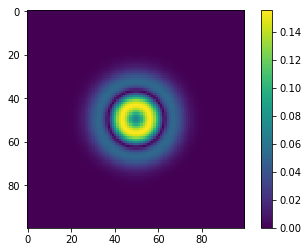

In [93]:
plt.imshow(np.abs(Tc3[-1] - Tc1[-1]))
plt.colorbar()
print("Error: ", np.linalg.norm(Tc3[-1].flatten() - Tc1[-1].flatten(), np.inf))

Error:  0.1165876049295207


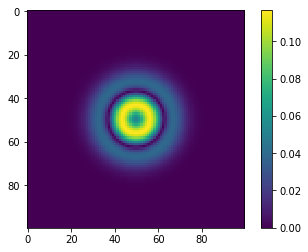

In [94]:
plt.imshow(np.abs(Tc2[-1] - Tc1[-1]))
plt.colorbar()
print("Error: ", np.linalg.norm(Tc2[-1].flatten() - Tc1[-1].flatten(), np.inf))

#### Space discretization

Testing $c=\frac{c'}{h^2}$

In [165]:
M, N = 128, 128
T0, A0, Y0 = temperatureFocus2(M, N, 10)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 75
dx = 100/M
c = 1/5*dx**-2
cs1 = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
Tcs1, Acs1, Fcs1 = cs1.propagate()
print(np.max(Tcs1[-1]))

141.60056942175245


In [166]:
M, N = 64, 64
T0, A0, Y0 = temperatureFocus2(M, N, 10)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 75
dx = 100/M
c = 1/5*dx**-2
cs2 = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
Tcs2, Acs2, Fcs2 = cs2.propagate()
print(np.max(Tcs2[-1]))

138.92023549875813


In [170]:
M, N = 32, 32
T0, A0, Y0 = temperatureFocus2(M, N, 5)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 75
dx = 100/M
c = 1/5*dx**-2
cs3 = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
Tcs3, Acs3, Fcs3 = cs3.propagate()
print(np.max(Tcs3[-1]))

133.7528367132182


In [ ]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 3, 1)
plt.imshow(Tgs1[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta x = \Delta y = M / 100$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 2)
plt.imshow(Tgs2[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta x = \Delta y = M / 200$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(Tgs2[-1][::2,::2] - Tgs1[-1]), origin="lower")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

Error:  19.484658189920495


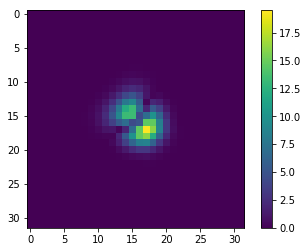

In [158]:
plt.imshow(np.abs(Tcs2[-1][::2,::2] - Tcs3[-1]))
plt.colorbar()
print("Error: ", np.linalg.norm(Tcs2[-1][::2,::2].flatten() - Tcs3[-1].flatten(), np.inf))

Error:  27.421614675481564


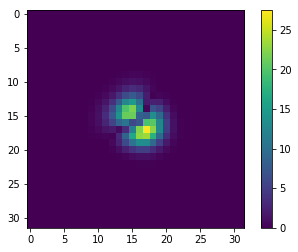

In [160]:
plt.imshow(np.abs(Tcs1[-1][::4,::4] - Tcs3[-1]))
plt.colorbar()
print("Error: ", np.linalg.norm(Tcs1[-1][::4,::4].flatten() - Tcs3[-1].flatten(), np.inf))

Error:  15.153857557204674


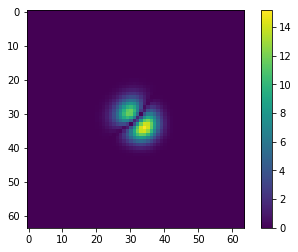

In [137]:
plt.imshow(np.abs(Tcs1[-1][::2,::2] - Tcs2[-1]))
plt.colorbar()
print("Error: ", np.linalg.norm(Tcs1[-1][::2,::2].flatten() - Tcs2[-1].flatten(), np.inf))

### Gamma scale

Testing $\gamma=\frac{\gamma'}{h}$

In [237]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 100
dx = 100/M
dt = 1
gamma = 1/8*dx**-1
Z = 0
b = 8
Ea = 0
h = 0
c = 0

gs1 = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
Tgs1, Ags1, Fgs1 = gs1.propagate()
i,j = np.unravel_index(Tgs1[-1].argmax(), Tgs1[-1].shape)
print(i, j, Tgs1[-1][i, j])

44 44 450.48450541637203


In [238]:
M, N = 200, 200
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 100
dx = 100/M
dt = 1/2
gamma = 1/8*dx**-1

gs2 = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
Tgs2, Ags2, Fgs2 = gs2.propagate()
i,j = np.unravel_index(Tgs2[-1].argmax(), Tgs2[-1].shape)
print(i, j, Tgs2[-1][i, j])

87 87 646.2568350395151


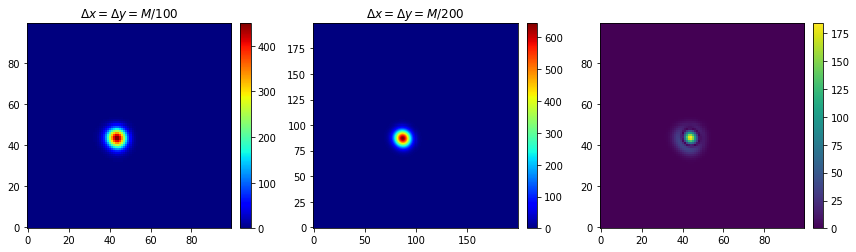

Error:  184.19878302208372


In [236]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 3, 1)
plt.imshow(Tgs1[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta x = \Delta y = M / 100$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 2)
plt.imshow(Tgs2[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta x = \Delta y = M / 200$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(Tgs2[-1][::2,::2] - Tgs1[-1]), origin="lower")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
print("Error: ", np.linalg.norm(Tgs2[-1][::2,::2].flatten() - Tgs1[-1].flatten(), np.inf))

Testing $\gamma=\gamma'\Delta t$

In [194]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 100
dt = 1
gamma = 1/8*dt
Z = 0
b = 8
Ea = 1
h = 0
c = 0

gt1 = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
Tgt1, Agt1, Fgt1 = gt1.propagate()
i,j = np.unravel_index(Tgt1[-1].argmax(), Tgt1[-1].shape)
print(i, j)

44 44


In [195]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 200
dt = 1/2
gamma = 1/8*dt
Z = 0
b = 8
Ea = 1
h = 0
c = 0

gt2 = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
Tgt2, Agt2, Fgt2 = gt2.propagate()
i,j = np.unravel_index(Tgt2[-1].argmax(), Tgt2[-1].shape)
print(i, j)

44 44


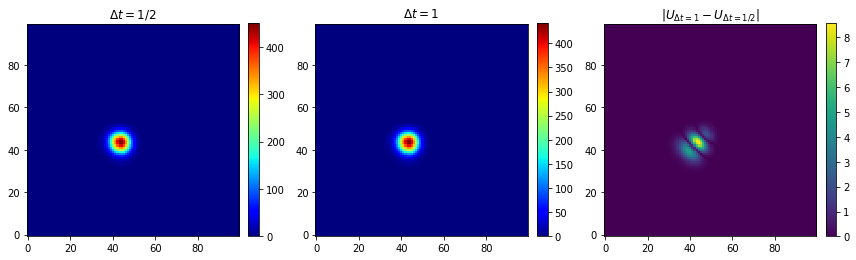

Error: 184.19878302208372


In [210]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 3, 1)
plt.imshow(Tgt1[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta t = 1/2$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 2)
plt.imshow(Tgt2[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta t = 1$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(Tgt2[-1] - Tgt1[-1]), origin="lower")
plt.title(r"$|U_{\Delta t = 1} - U_{\Delta t = 1/2}|$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
print("Error:", np.linalg.norm(Tgs2[-1][::2,::2].flatten() - Tgs1[-1].flatten(), np.inf))

### Z Scale

Testing that $Z$ doesn't depend on $\Delta x$. 

In [265]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 4
gamma = 0
Z = 0.1 
b = 8
Ea = 1
h = 0
c = 0

dtenv = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
dtsenv, Asenv, fsenv = dtenv.propagate()
print(np.max(dtsenv[-1]))

2469.09544373


In [232]:
widgets.interact(dtenv.plotSimulation, t=widgets.IntSlider(min=0, max=len(dtsenv)-1, 
    continuous_update=False), temperatures=widgets.fixed(dtsenv), fuels=widgets.fixed(fsenv), trees=widgets.fixed(Asenv))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=3), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [266]:
M, N = 300, 300
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 4

Z = 0.1


dtenv = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
dtsenv, Asenv, fsenv = dtenv.propagate()
print(np.max(dtsenv[-1]))

2513.29780168


In [270]:
widgets.interact(dtenv.plotSimulation, t=widgets.IntSlider(min=0, max=len(dtsenv)-1,description='Timestep:',
    continuous_update=False), temperatures=widgets.fixed(dtsenv), fuels=widgets.fixed(fsenv), trees=widgets.fixed(Asenv))

interactive(children=(IntSlider(value=0, continuous_update=False, description='Timestep:', max=199), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

Testing $Z=Z'\, \Delta t$

In [267]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 100
dt = 1
Z = 0.1*dt


dtenv = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
dtsenv, Asenv, fsenv = dtenv.propagate()
print(np.max(dtsenv[-1]))

8872.61482312


In [268]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 200
dt = 1/2
Z = 0.1*dt


dtenv = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
dtsenv, Asenv, fsenv = dtenv.propagate()
print(np.max(dtsenv[-1]))

8871.09304421


### Cooling Factor

Testing $h_{cool}$ doesn't depend on $h=\Delta x=\Delta y$.

In [271]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 20

gamma = 0
Z = 0
b = 8
Ea = 1
h = 0.1
c = 0

dtenv = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
dtsenv, Asenv, fsenv = dtenv.propagate()
print(np.max(dtsenv[-1]))

154.314050771


In [272]:
widgets.interact(dtenv.plotSimulation, t=widgets.IntSlider(min=0, max=len(dtsenv)-1, description='Timestep:',
    continuous_update=False), temperatures=widgets.fixed(dtsenv), fuels=widgets.fixed(fsenv), trees=widgets.fixed(Asenv))

interactive(children=(IntSlider(value=0, continuous_update=False, description='Timestep:', max=19), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [273]:
M, N = 200, 200
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 20

h = 0.1


dtenv = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
dtsenv, Asenv, fsenv = dtenv.propagate()
print(np.max(dtsenv[-1]))

159.33776092


In [274]:
widgets.interact(dtenv.plotSimulation, t=widgets.IntSlider(min=0, max=len(dtsenv)-1, description='Timestep:',
    continuous_update=False), temperatures=widgets.fixed(dtsenv), fuels=widgets.fixed(fsenv), trees=widgets.fixed(Asenv))

interactive(children=(IntSlider(value=0, continuous_update=False, description='Timestep:', max=19), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

Testing $h=h'\Delta t$

In [236]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 100
dt = 1
gamma = 0
Z = 0
b = 8
Ea = 1
h = 0.1*dt
c = 0

dtenv = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
dtsenv, Asenv, fsenv = dtenv.propagate()
print(np.max(dtsenv[-1]))

30.0271594502


In [275]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 200
dt = 1/2
gamma = 0
Z = 0
b = 8
Ea = 1
h = 0.1*dt
c = 0

dtenv = temp.discrete(c, gamma, times, T0, A0, Y1, wind2[0:], b, maxTemp, Ea, Z, H, h, T_ref) 
dtsenv, Asenv, fsenv = dtenv.propagate()
print(np.max(dtsenv[-1]))

30.0339554892


In [414]:
T0 = 10
alpha = 0.1

times = 100
 
T = T0
W = np.random.normal(0,1,times)
for i in range(times):
    
    T = T * (1 + alpha)  + W[i]

In [415]:
T

160579.45124392002

In [ ]:
T0 = 10
alpha = 0.1

times = 200
 
T = T0
W = np.random.normal(0,1,times)

for i in range(times):
    
    T = T * (1 + alpha)  + W[i]

Hay que agregar un plot para jugar con todos los parametros.

# Continuous Model

\begin{equation}
    \partial T(i,j,k)= (c' \, \partial t + \sigma_1' \, \partial Z_{i,j}(t))\, \Delta T(i,j,k) + \sigma_2' \,\partial W_{i,j}(t)
\end{equation}

#### With $\sigma_1=\sigma_2=0$

In [40]:
def temperatureCFocus(M, N):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, M)
    X, Y = np.meshgrid(x, y)
    return 1e3*np.exp(-1000*((X-.5)**2 + (Y-.5)**2))

In [41]:
M, N = 50, 50  

initial, A = temperatureFocus(M, N)

# Parameters
mu = 1/5 
T = 1000
dt = 1e-4
b = 8
maxTemp = 1000

In [42]:
ct = temp.continuous(initial, mu, dt, T, b, maxTemp, A=A)
cta, Aa, Wa = ct.solvePDE()

In [43]:
widgets.interact(ct.plotTemperatures, t=widgets.IntSlider(min=0, max=len(cta)-1), 
                 temperatures=widgets.fixed(cta))

interactive(children=(IntSlider(value=0, description='t', max=1000), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

#### Approach 1 $\sigma_1\neq 0$

In [44]:
ctb, Ab, Wb = ct.solvePDE(1/3)

In [45]:
widgets.interact(ct.plotTemperatures, t=widgets.IntSlider(min=0, max=len(ctb)-1), 
                 temperatures=widgets.fixed(ctb))

interactive(children=(IntSlider(value=0, description='t', max=1000), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

#### Approach 1 $\sigma_1,\sigma_2\neq 0$

In [46]:
ctc, Ac, Wc = ct.solvePDE(1/8, 2000)

In [47]:
widgets.interact(ct.plotTemperatures, t=widgets.IntSlider(min=0, max=len(ctc)-1), 
                 temperatures=widgets.fixed(ctc))

interactive(children=(IntSlider(value=0, description='t', max=1000), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

# Data assimilation

## Topography

In [48]:
import csv

In [49]:
def CSVElevation(path):
    x, y, z = [], [], []
    with open(path, newline='') as csvfile:
        data = csv.reader(csvfile, delimiter='\t', quotechar='|')
        next(data, None)
        for row in data:
            y.append(float(row[1]))
            x.append(float(row[2]))
            z.append(float(row[3]))
        
    return np.array(x), np.array(y), np.array(z)

In [50]:
M, N = 100, 100

start_lat, start_lng = -33.088309, -71.655849
end_lat, end_lng = -33.141629, -71.594160

In [51]:
x, y, z = CSVElevation("data/valpo_elevation.csv")

In [52]:
X = x.reshape(M, N)
Y = y.reshape(M, N)
Z = z.reshape(M, N)

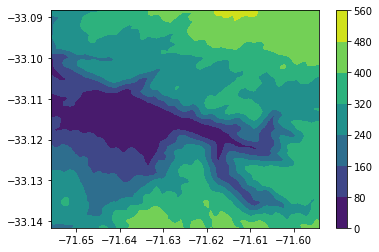

In [53]:
plt.contourf(X, Y, Z)
plt.colorbar()
plt.show()

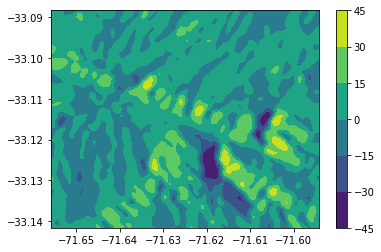

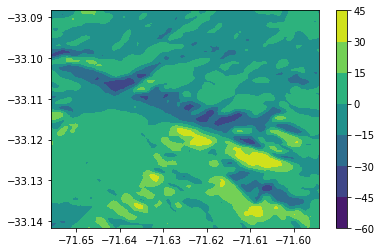

In [54]:
# Compute gradient
dx = 1.#X[0, 1] - X[0, 0]
dy = 1.#Y[0, 1] - Y[0, 0]
#Z_x = np.gradient(Z, dx, axis=1)
#Z_y = np.gradient(Z, dy, axis=0)
Z_x = np.gradient(Z, axis=1)
Z_y = np.gradient(Z, axis=0)
plt.contourf(X, Y, Z_x)
plt.colorbar()
plt.show()
plt.contourf(X, Y, Z_y)
plt.colorbar()
plt.show()

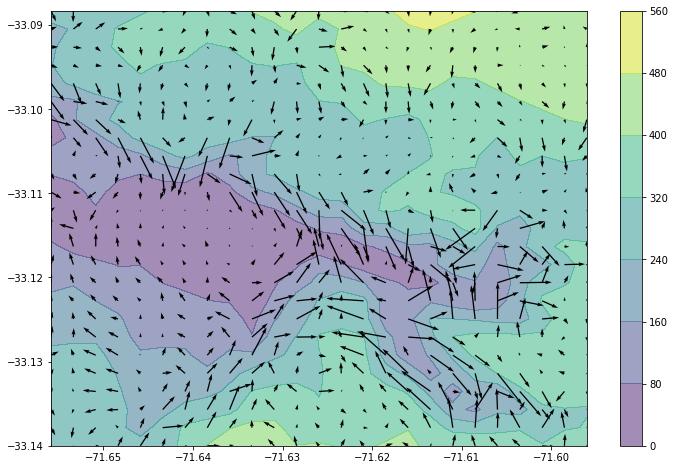

In [55]:
p = 4

nZ_x = np.zeros((M//p, N//p))
nZ_y = np.zeros((M//p, N//p))

for i in range(M//p):
    for j in range(N//p):
        nZ_x[i, j] = np.sum(Z_x[p*i:p*(i+1), p*j:p*(j+1)]) / (p**2)
        nZ_y[i, j] = np.sum(Z_y[p*i:p*(i+1), p*j:p*(j+1)]) / (p**2)
    
#elev = plt.contourf(X[::s,::s], Y[::s,::s], Z[::s,::s], alpha=.5)
plt.figure(figsize=(12, 8))
elv = plt.contourf(X[::p,::p], Y[::p,::p], Z[::p,::p], alpha=.5)
plt.quiver(X[::p,::p], Y[::p,::p], nZ_x, nZ_y)
plt.colorbar(elv)
plt.show()

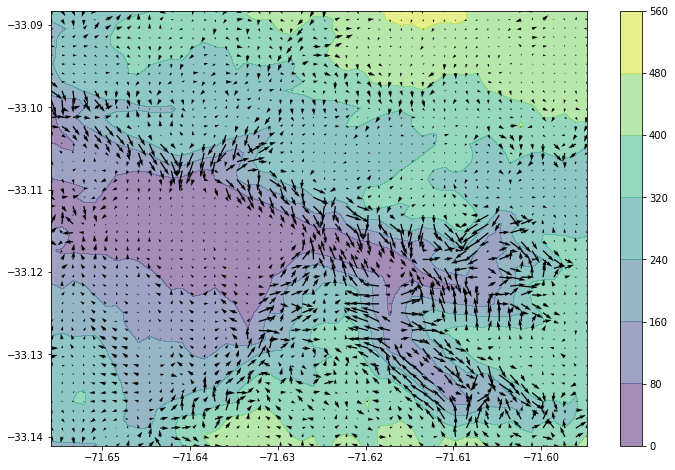

In [56]:
s = 2
plt.figure(figsize=(12, 8))
elev = plt.contourf(X[::s,::s], Y[::s,::s], Z[::s,::s], alpha=.5)
plt.quiver(X[::s,::s], Y[::s,::s], Z_x[::s,::s], Z_y[::s,::s])
plt.colorbar(elev)
plt.show()

## Wind

In [57]:
from scipy import interpolate

In [58]:
v_spe = np.load('data/speed.npy')
v_dir = np.load('data/direction.npy')

In [59]:
T = 50
speed = v_spe[-T:]#v_spe[:T]
direction = np.radians(v_dir[-T:])
t = np.linspace(0, 10*T, T)
#plt.plot(t, speed)
#plt.plot(t, direction)
#plt.show()

fs = interpolate.interp1d(t, speed, kind='cubic')
fd = interpolate.interp1d(t, direction, kind='cubic')
fine_t = np.linspace(0, 10*T, 10*T)
int_speed = fs(fine_t)
int_direction = fd(fine_t)
#plt.plot(fine_t, int_speed)
#plt.plot(fine_t, int_direction)
#plt.show()

xv = int_speed * np.cos(int_direction)
yv = int_speed * np.sin(int_direction)
#plt.plot(xv)
#plt.plot(yv)
#plt.show()

In [60]:
ONES = np.ones((10, 10))

In [61]:
def plotWind(i, u, v):
    plt.quiver(u[i]*ONES, v[i]*ONES)
    plt.show()

In [62]:
widgets.interact(plotWind, i=widgets.IntSlider(min=0, max=len(xv)-1), u=widgets.fixed(xv), v=widgets.fixed(yv))

interactive(children=(IntSlider(value=0, description='i', max=499), Output()), _dom_classes=('widget-interact',))

<function __main__.plotWind>

In [63]:
winds = list()
for i in range(len(xv)):
    winds.append((1e-2*xv[i], 1e-2*yv[i]))